# MCLの説明

- MCL
    - 自己位置推定手法の一つ
    - ロボットの姿勢（位置、向き）を「パーティクル」を複数ばら撒くことで近似表現（図1）
        - パーティクル
            - ロボットの分身
            - ロボットの姿勢情報と、実ロボットがその姿勢になる確率を表す重みを持つ（図1）
![fig1](../fig/fig1.png)

## 処理の流れ

### 0. パーティクルの初期化（図2）

- 全てのパーティクルの姿勢情報を実ロボットの姿勢で初期化
- パーティクルの総数が$n$個の場合、重みは$\frac{1}{n}$で初期化
![fig2](../fig/fig2.png)

### 1. ロボットが移動したときのパーティクルの更新（図3）

- ロボットに速度指令値$u_t$が入力され移動したとき、パーティクルも移動
- すべてのパーティクルの姿勢情報を更新
- 移動させるときには、移動に生じる雑音を考慮してパーティクルを分散させる
![fig1](../fig/fig3.png)

### 2. センサ（深度カメラ）の観測によるパーティクルの更新（図4）

- 想定しているセンサは360度を観測できる深度カメラ
- ランドマーク（目印）を観測することでパーティクルを更新
- 次の処理を環境内にあるランドマークすべてに対して計算
    - ロボットからランドマークまでの距離$l^*$となす角$\phi^*$を観測によって取得
    - 各パーティクルとランドマークまで距離$l_i$となす角$\phi_i$を計算
    - $l^*$と$l_i$、$\phi^*$と$\phi_i$がどれだけ同じかという数値（尤度）を計算
    - 尤度を現在の重みに乗算
- ロボットの真の姿勢に近いパーティクル程、重みが大きくなる
    - 図4だと青→黄→赤の順で尤度が大きくなる
![fig1](../fig/fig4.png "図4")

### 3. リサンプリング（図5）

- この作業によって、バグの発生や2の処理によって生まれる重みの偏りを防止
- 新しいパーティクル群を現在のパーティクル群から選んで作成
    - パーティクルの偏りを防止
    - 重みの大きいパーティクル程選ばれやすく、小さいものほど選ばれにくい
        - 図5では図4の尤度の大きいパーティクルが選ばれやすいことを表している
- 上記の処理を行った後、重みを$\frac{1}{n}$に更新
    - 重みが0に近づいていくバグの発生を防止
![fig1](../fig/fig5.png)

## アルゴリズムの実装

### 使用するライブラリのインポート

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
from matplotlib.patches import Circle
import matplotlib.collections as mc 
import random
import copy

### ランドマークとその観測結果、ロボット、パーティクルを描画する関数の実装

In [185]:
def draw(ax, title, landmarks, actual_pose, particles, zs=None):
    # ----グラフの設定----
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_title(title)
    # --------------------
    
    # ----ランドマーク----
    x = [landmark[0] for landmark in landmarks]
    y = [landmark[1] for landmark in landmarks]
    plt.scatter(x, y, marker='*')
    # --------------------
    
    # ----ロボット----
    x, y, theta = actual_pose[0], actual_pose[1], actual_pose[2]
    cr = 0.5
    cir = Circle(xy=(x, y), radius=cr, fill=False)
    x_end = x + cr * math.cos(theta)
    y_end = y + cr * math.sin(theta)
    plt.plot([x, x_end], [y, y_end], color="black")
    ax.add_artist(cir)
    # ----------------
    
    # ----パーティクル----
    xs = [particle.p[0] for particle in particles]
    ys = [particle.p[1] for particle in particles]
    xe = [math.cos(particle.p[2])*particle.w for particle in particles]
    ye = [math.sin(particle.p[2])*particle.w for particle in particles]
#     scales = [particle.w for particle in particles]
    plt.quiver(xs, ys, xe, ye, color='green', alpha=0.4)
    # --------------------
    
    # ----観測結果----
    if(zs != None):
        lines = [[(x, y), (x+z[0]*math.cos(z[1]), y+z[0]*math.sin(z[1]))] for z in zs]
        lines_plot = mc.LineCollection(lines, color='red')
        ax.add_collection(lines_plot)
    # ----------------


### 1つ前の時間の姿勢と現在入ってきた速度入力から現在の姿勢を計算する関数の実装

In [186]:
def cmd_vel2xyt(now_p, cmd_vel, dt):
    p = [0, 0, 0]
    if cmd_vel[1] == 0.0:
        p = [
            now_p[0] + cmd_vel[0]*math.cos(now_p[2])*dt, 
            now_p[1] + cmd_vel[0]*math.sin(now_p[2])*dt, 
            now_p[2] + cmd_vel[1]*dt
        ]
    else:
        theta_tmp = now_p[2] + cmd_vel[1]*dt
        p = [
            now_p[0] + cmd_vel[0]/cmd_vel[1]*(math.sin(theta_tmp)-math.sin(now_p[2])), 
            now_p[1] + cmd_vel[0]/cmd_vel[1]*(-math.cos(theta_tmp)+math.cos(now_p[2])), 
            now_p[2] + cmd_vel[1]*dt
        ]
    while p[2] >= math.pi:
        p[2] -= 2*math.pi

    while p[2] < -math.pi:
        p[2] += 2*math.pi
    return p

### ランドマークを観測する関数の実装

- センサに加わる雑音も実装
    - ランドマークとの距離：真値に対して[-0.5, 0.5]の値をランダムに加算
    - ランドマークとなす角：真値に対して[-0.05, 0.05]の値をランダムに加算

In [187]:
def observe_landmark(pose, landmarks):
    x, y = pose[0], pose[1]
    zs = []
    for landmark in landmarks:
        diff_x = landmark[0] - x
        diff_y = landmark[1] - y
        r = math.sqrt(diff_x**2 + diff_y**2)
        phi = math.atan2(diff_y, diff_x)
        noise_r = (random.random() - 0.5) * 1.0
        noise_phi = (random.random() - 0.5) * 0.1
        r += noise_r
        phi += noise_phi
        zs.append([r, phi])
    return zs

### パーティクルクラスの定義

In [188]:
class Particle():
    def __init__(self, landmarks, p, motion_noise_sigma, cmd_vel, dt, weight, observe_noise_sigma):
        self.landmarks = landmarks
        self.p = p
        self.motion_noise_sigma = motion_noise_sigma
        self.cmd_vel = cmd_vel
        self.dt = dt
        
        s = motion_noise_sigma
        motion_cov = np.diag([s[0]**2, s[1]**2, s[2]**2, s[3]**2])
#         print(motion_cov)
        self.motion_update_mult_norm = multivariate_normal([0, 0, 0, 0], motion_cov)
        
        self.w = weight
        self.observe_noise_sigma = observe_noise_sigma
    
    # ロボットが移動したときのパーティクルの更新
    # パーティクルの位置を雑音を考慮した速度指令値分だけ動かす
    def motion_update(self):
#         print(self.motion_update_mult_norm.rvs())
        noise_cmd_vel = self.add_motion_noise()
        self.p = cmd_vel2xyt(self.p, noise_cmd_vel, self.dt)
    
    # 雑音を考慮した分の速度指令値を計算
    def add_motion_noise(self):
        noises = self.motion_update_mult_norm.rvs()
        noise_cmd_vel = [
            self.cmd_vel[0] + noises[0]*math.sqrt(abs(self.cmd_vel[0])/self.dt) + noises[1]*math.sqrt(abs(self.cmd_vel[1])/self.dt), 
            self.cmd_vel[1] + noises[2]*math.sqrt(abs(self.cmd_vel[0])/self.dt) + noises[3]*math.sqrt(abs(self.cmd_vel[1])/self.dt)
        ]
        return noise_cmd_vel
    
    # センサ（深度カメラ）の観測によるパーティクルの更新
    def observed_update(self, zs):
        p_zs = observe_landmark(self.p, landmarks)
        for z, p_z in zip(zs, p_zs):
#             print(z)
#             print(p_z)
            observe_cov = np.diag([(p_z[0]*self.observe_noise_sigma[0])**2, self.observe_noise_sigma[1]**2])
            observe_update_mult_norm = multivariate_normal(cov=observe_cov, mean=p_z)
            likelihood = observe_update_mult_norm.pdf(z)
#             print(likelihood)
            self.w *= likelihood
#         print(f'weight: {self.w}')
            

### リサンプリング

In [189]:
def resampling(particles):
    w_cumsum = np.cumsum([particle.w for particle in particles])
    if w_cumsum[-1] < 1e-100:
        w_cumsum = [w+1e-100 for w in w_cumsum]
#     print(w_cumsum)
    w_sum = w_cumsum[-1]
    
    space = w_sum / len(particles)
    p_weight = random.uniform(0, space)
    new_p = []
    new_index = 0
    while len(new_p) < len(particles):
#         print(len(new_p), new_index)
#         if(new_index >= len(particles)):
#             new_index = len(particles)
        if p_weight < w_cumsum[new_index]:
            new_p.append(particles[new_index])
            p_weight += space
        
        else:
#             p_weight += space
            new_index += 1
    return new_p


## 実行

- 実ロボットに入力する速度指令値に雑音を実装
    - 移動によって生じる雑音を表現
    - 並進速度：真値に対して[-0.1, 0.1]の値をランダムに加算
    - 角速度：真値に対して[-0.0375, 0.0375]の値をランダムに加算
- ランドマークと時刻$t$における各処理の後のロボットとパーティクルをグラフにプロット
    - ランドマーク：星
    - ロボット：黒い丸、向きを線で表している
    - パーティクル：緑の矢印、重みが大きいほど矢印が長い
- 処理の流れで説明した各処理の後は次のタイトルで表している
    - 0番目：initialize
    - 1番目：motion update
    - 2番目：observe update
    - 3番目：resampling
- $t=10$までシミュレーションを実行

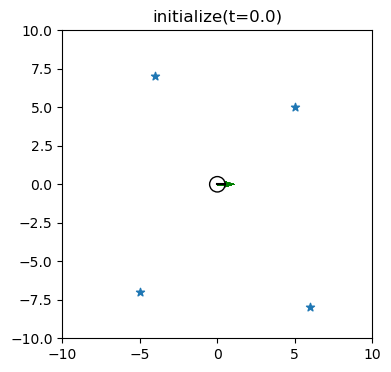

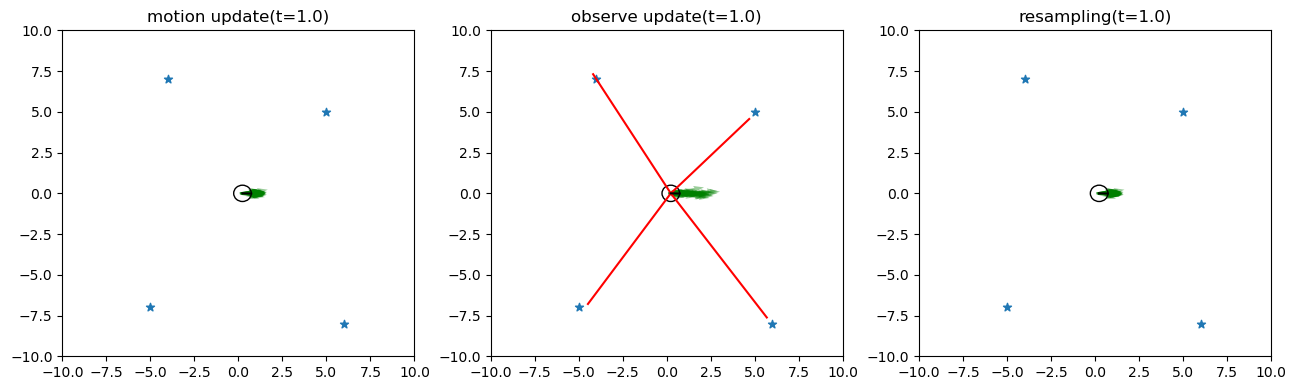

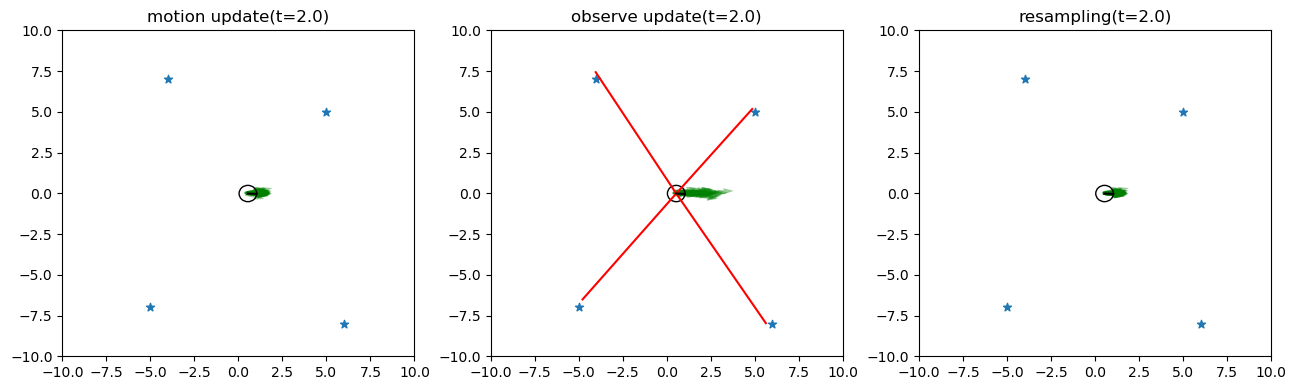

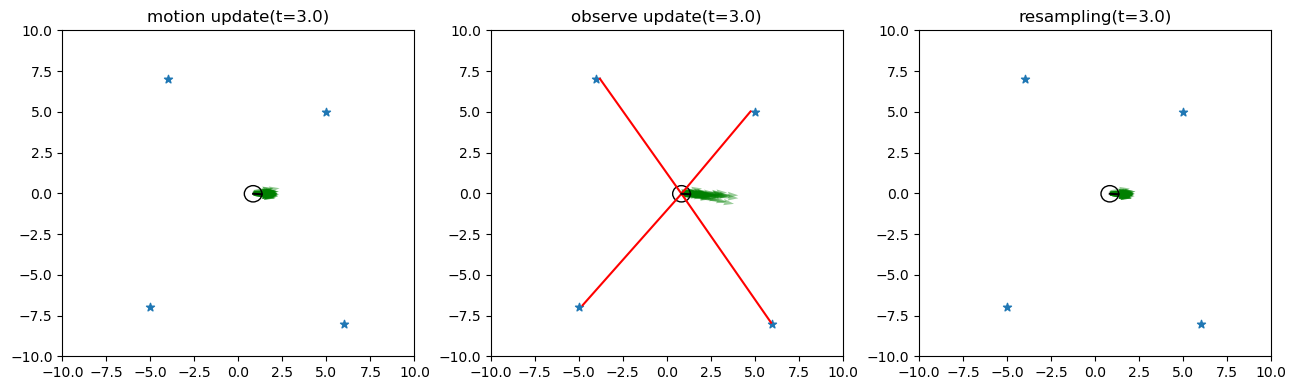

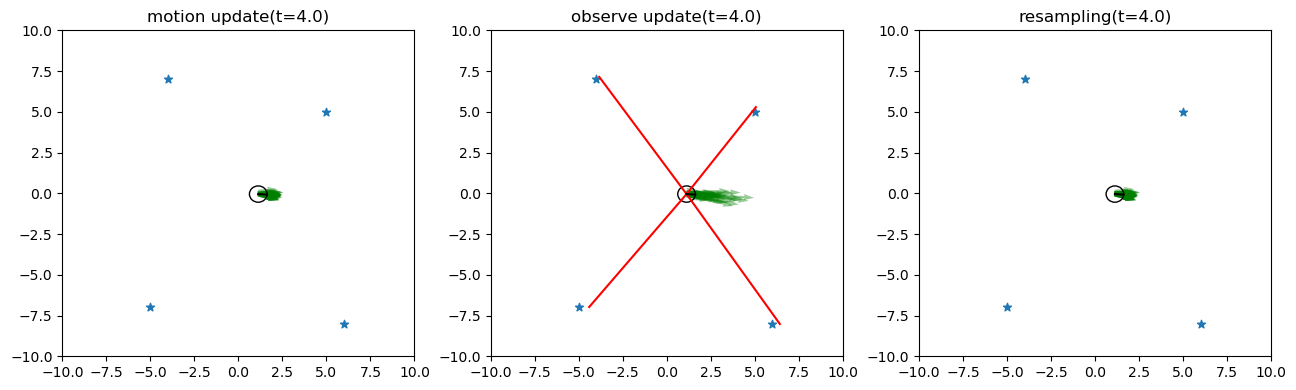

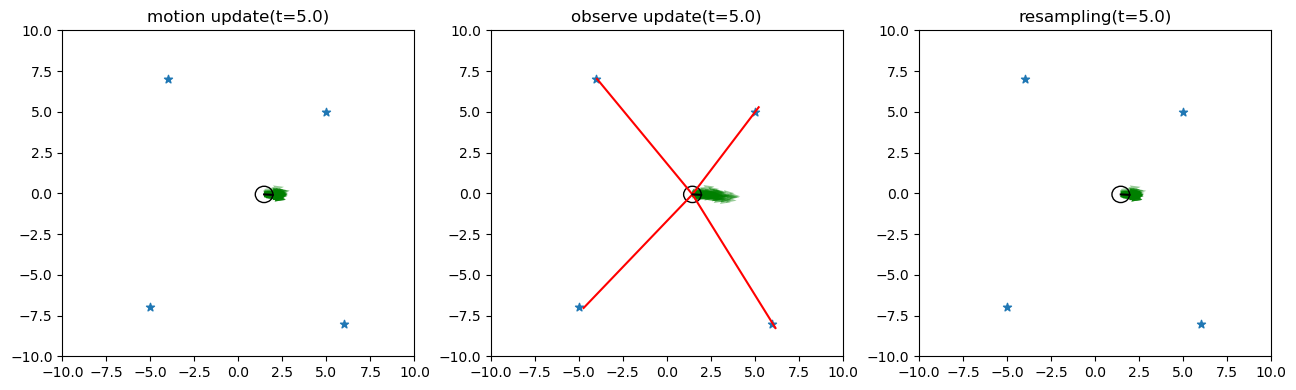

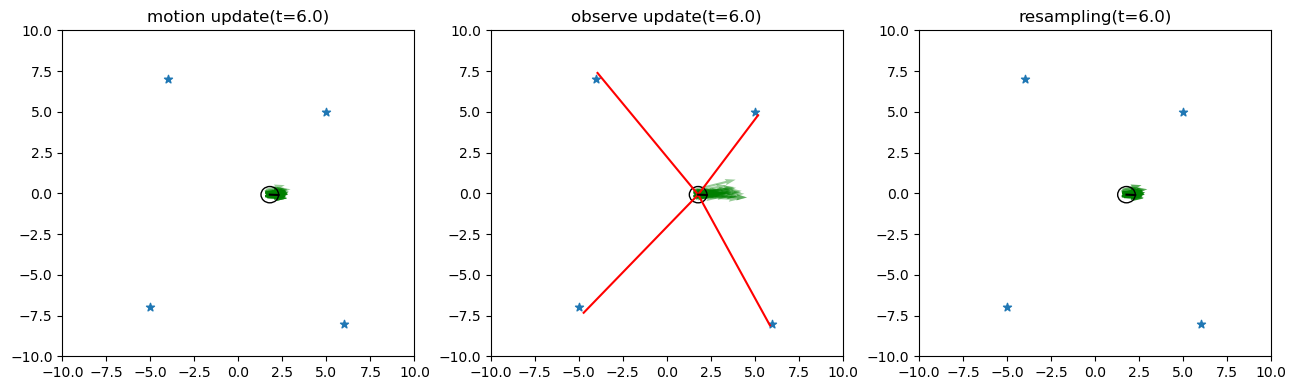

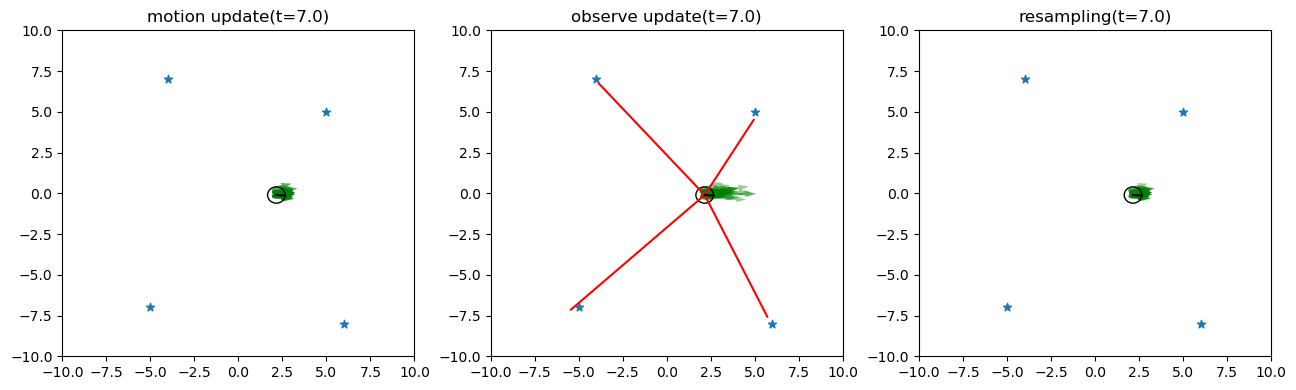

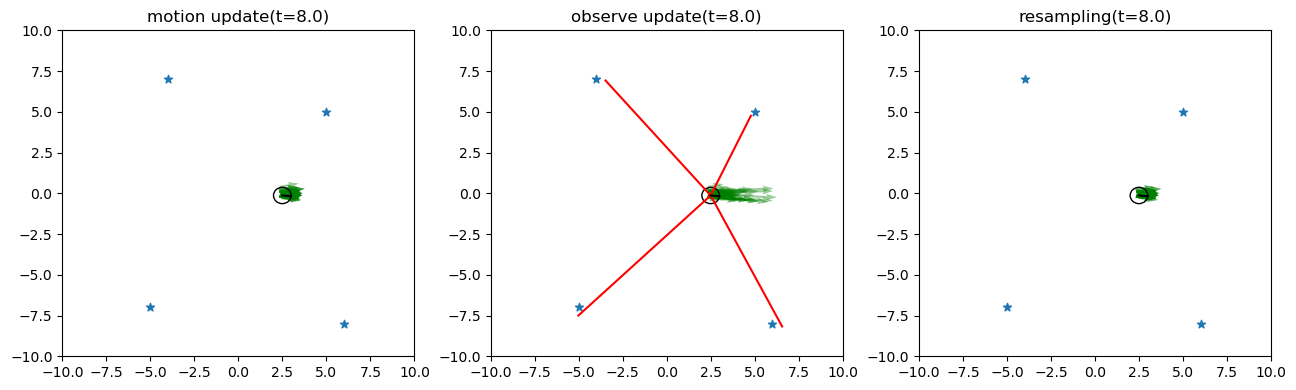

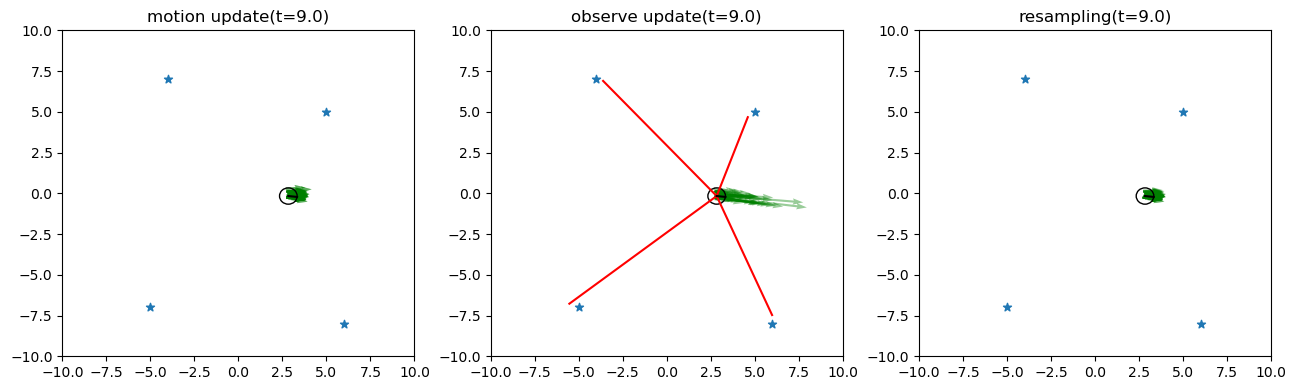

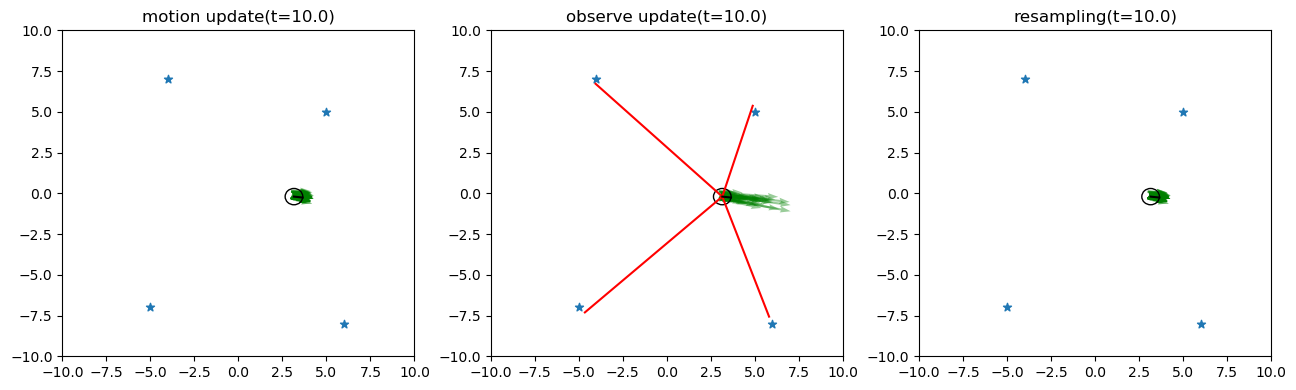

In [191]:
p0 = [0.0, 0.0, 0.0] # ロボットの初期位置
motion_noise_sigma = [0.2, 0.01, 0.15, 0.2]
cmd_vel = [0.3, 0.0]
landmarks = np.array([[5, 5], [-4, 7], [6, -8], [-5, -7]])
weight = 1 / n
observe_noise_sigma = [0.5, 0.05]
dt = 1.0
p = p0
n =100 # パーティクルの数
imp_n = 10
particles = [Particle(landmarks, p0, motion_noise_sigma, cmd_vel, dt, weight, observe_noise_sigma) for i in range(n)]

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
draw(ax, 'initialize(t=0.0)', landmarks, p, particles) # 時刻0における状態の描画

for i in range(imp_n):
    actual_cmd_vel = [
        cmd_vel[0] + (random.random()-0.5)*0.2, 
        cmd_vel[1] + (random.random()-0.5)*0.075, 
    ]
    p = cmd_vel2xyt(p, actual_cmd_vel, dt)
    
    for particle in particles:
        particle.motion_update()
#     fig = plt.figure(figsize=(4, 4))
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_subplot(131)
    draw(ax, f'motion update(t={i*dt+dt})', landmarks, p, particles)
    
    zs = observe_landmark(p, landmarks)
    for particle in particles:
        particle.observed_update(zs)
    ax = fig.add_subplot(132)
    draw(ax, f'observe update(t={i*dt+dt})', landmarks, p, particles, zs)
    
    new_ps = resampling(particles)
    particles = [copy.deepcopy(new_p) for new_p in new_ps]
    for particle in particles:
        particle.w = 1 / len(particles)
#         print(particle.w)
#     print('after resampling')
    ax = fig.add_subplot(133)
    draw(ax, f'resampling(t={i*dt+dt})', landmarks, p, particles)
    
    plt.tight_layout()
    plt.show()